In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import warnings
import pickle
import sys
import os

import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

sys.path.append('../src/')
from dataset import AvgVideoDataModule
from model import (
    MobileNetV3,
    MobileNetV2,
    ResNet18
)
from utils import (
    avg_video,
    predict_dataloader
)

warnings.filterwarnings("ignore")

2023-06-12 19:48:20.406820: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 19:48:21.610015: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
DATA_DIR = Path('../data/')
SRC_DIR = Path('../src/')
SUBMIT_PATH = Path('../output/submit_avg_video_clf/')
MODEL_DIR = Path('../models/')

CLASSES = ["bridge_down", "bridge_up", "no_action", "train_in_out"]
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SEED = 42

In [4]:
with open(SRC_DIR.joinpath('id2label.pkl'), 'rb') as fp:
    id2label = pickle.load(fp)
    label2id = {v: k for k, v in id2label.items()}

In [5]:
np.random.seed(SEED)
torch.manual_seed(SEED)
pl.seed_everything(SEED);

Global seed set to 42


# Data

In [6]:
# Read extended data
train_clips = pd.read_excel(DATA_DIR.joinpath('dataset_located.xlsx'))
train_clips['fname'] = train_clips['fname'].str.replace('.mp4', '.npy')
train_clips['location'] = train_clips['location'].replace({'ladder': 'station_outside'})

In [7]:
# Check station distribution
train_clips.location.value_counts()

turquoise_bridge    187
gate                133
rusty_bridge        106
station_outside      58
two_stations         12
Name: location, dtype: int64

In [8]:
# Check class distribution
train_clips.label.value_counts()

bridge_down     306
bridge_up        75
train_in_out     66
no_action        49
Name: label, dtype: int64

In [9]:
# Put most difficult stations to train
train_data_part1 = train_clips[train_clips['location'].isin(['two_stations', 'station_outside'])]
# Get subsample from other stations for train
train_data_part2 = train_clips[~train_clips['location'].isin(['two_stations', 'station_outside'])] \
                              .sample(300, random_state=SEED)
train_data = pd.concat([train_data_part1, train_data_part2])
# Put other samples to validation
val_data = train_clips[~train_clips.index.isin(train_data.index)]

# Model training

In [10]:
datamodule = AvgVideoDataModule(
    train_data, 
    val_data,
    augment=True,
    batch_size=16,
    every_n_frame=50,
    num_workers=0
)

# model = MobileNetV2(
#     freeze_pretrained=False,
#     lr=5e-5,
#     weight_decay=0.1,
#     class_weights=None
# )

# model = MobileNetV3(
#     freeze_pretrained=False,
#     lr=5e-5,
#     weight_decay=0.1,
#     class_weights=None
# )

model = ResNet18(
    freeze_pretrained=False,
    lr=5e-5,
    weight_decay=0.1,
    label_smoothing=0.0
)

In [11]:
early_stopping = EarlyStopping(monitor='loss_val',
                               mode='min',
                               patience=50)

checkpoint = ModelCheckpoint(monitor='loss_val',
                             mode='min',
                             dirpath=MODEL_DIR,
                             filename='resnet18__{epoch}-{f1_train:.2f}-{loss_train:.2f}-{f1_val:.2f}-{loss_val:.2f}-step50',
                             save_weights_only=True,
                             save_top_k=3)

trainer = pl.Trainer(
    max_epochs=100,
    accelerator='gpu',
    devices=[0],
    callbacks=[early_stopping, checkpoint],
    logger=False,
    precision=16
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(model, datamodule)

# Save model to ONNX

In [21]:
# Load trained model
model_filename = 'resnet18__epoch=94-f1_train=1.00-loss_train=0.00-f1_val=1.00-loss_val=0.00-step50.ckpt'
trained_model_path = MODEL_DIR.joinpath(model_filename)
model_trained = ResNet18.load_from_checkpoint(trained_model_path)

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
# Save model to ONNX
model_trained.to('cpu')
model_trained.eval()
sample = torch.randn(1, 3, 224, 224)
onnx_model_path = SUBMIT_PATH.joinpath('resnet18_avg_video.onnx')
with torch.no_grad():
    torch.onnx.export(
        model_trained,
        sample,
        onnx_model_path,
        export_params=True,
        opset_version=11,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={'input': {0: 'batch_size',
                                1: 'channels',
                                2: 'height',
                                3: 'width'}}
    )

# Error analysis

In [12]:
datamodule.setup()
train_dataloader = torch.utils.data.DataLoader(
    datamodule.train_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

model_trained.to(DEVICE)
model_trained.eval()  # Set the model to evaluation mode

train_preds = predict_dataloader(model_trained, train_dataloader, 'cuda:0')

Inference:   0%|          | 0/10 [00:00<?, ?it/s]

In [13]:
datamodule.setup()
val_dataloader = datamodule.val_dataloader()

val_preds = predict_dataloader(model_trained, val_dataloader, 'cuda:0')

Inference:   0%|          | 0/11 [00:00<?, ?it/s]

In [14]:
train_labels = train_data['label'].map(label2id)
print(classification_report(train_labels, train_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       185
           1       1.00      1.00      1.00        45
           2       1.00      1.00      1.00        39
           3       1.00      1.00      1.00        51

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320



In [15]:
val_labels = val_data['label'].map(label2id)
print(classification_report(val_labels, val_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       121
           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        15

    accuracy                           1.00       176
   macro avg       1.00      1.00      1.00       176
weighted avg       1.00      1.00      1.00       176



In [16]:
train_data['preds'] = train_preds
train_data['preds'] = train_data['preds'].map(id2label)

In [17]:
val_data['preds'] = val_preds
val_data['preds'] = val_data['preds'].map(id2label)

In [18]:
train_errors = train_data.query('label != preds')
train_errors

,fname,label,place,location,camera_id,comment,preds


In [19]:
# Check train errors
for _, row in train_errors.iterrows():
    plt.figure()
    clip_path = DATA_DIR.joinpath('train_np', row['label'], row['fname'])
    clip = np.load(clip_path)
    plt.imshow(avg_video(clip, every_n_frame=50))

In [20]:
val_errors = val_data.query('label != preds')
val_errors

,fname,label,place,location,camera_id,comment,preds


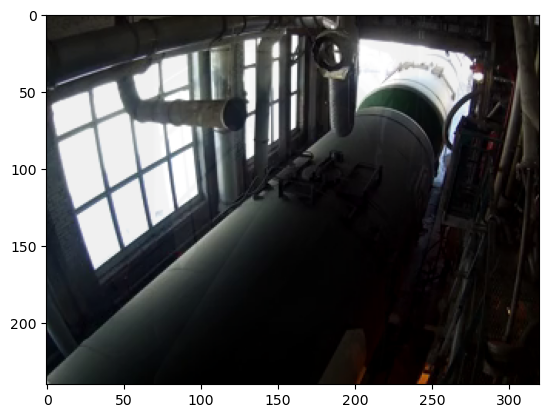

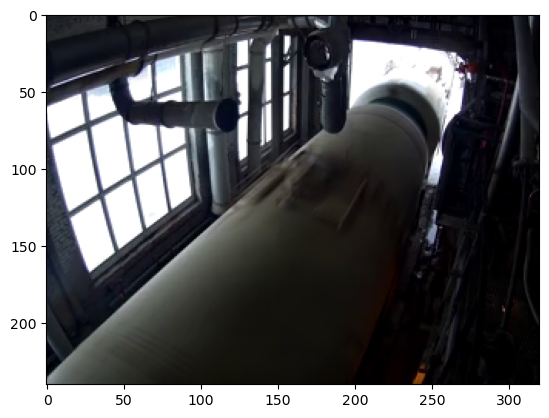

In [25]:
# Check val errors
for _, row in val_errors.iterrows():
    plt.figure()
    clip_path = DATA_DIR.joinpath('train_np', row['label'], row['fname'])
    clip = np.load(clip_path)
    plt.imshow(avg_video(clip, every_n_frame=15))